In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import re

evalTime = 14.


path2file_ = r'CSTimin_exud/{}_1476_{}_10to14_20mn_0s_128/'

In [4]:
def getVal(mypath, filename,dtype=float,extension='.txt', header="infer",names = None):
    fullpath = pathresults +mypath+filename
    data_file_delimiter = ","
    if names is None:
        largest_column_count = 0
        with open(fullpath, 'r') as temp_f:
            lines = temp_f.readlines()
        last_line = lines[-1].strip()
        #print('last_line',last_line)
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        largest_column_count = len(array_from_last_line)
        names = [i for i in range(0, largest_column_count)]
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, 
                          header = header, names = names)
        #print('cst',cst.shape)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names)
    return cst
    
def get_last_line_as_numpy_array(file_path,  dtype = float, verbose = False):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        
        try:
            last_line = lines[-1].strip()
        except:
            print('timeLine',file_path, len(lines))
            raise Exception

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        if verbose:
            print(file_path, len(array_from_last_line), end=", ")

        return array_from_last_line

def getCylIdx(path2file):
    fileName = "rhizoSegsId.txt"
    fullpath = path2file+fileName
    rhizoSegsId = get_last_line_as_numpy_array(fullpath, dtype = int, verbose = True)
    print('rhizoSegsId',max(rhizoSegsId))
    return rhizoSegsId
    
def list_files_with_prefix(folder_path, prefix):
    file_names = []
    for file_name in os.listdir(pathresults+folder_path):
        if file_name.startswith(prefix):
            file_names.append(file_name)
    return file_names

# cylinder max konz (per cell)
def getData_(cid,gId,path2file):
    fileName = "cyl_val/Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    if cid == volIdx:
        return sum(cVol)
    elif cid <= 9:
        if cid <= 2:# == 0:
            fileName = "cyl_val/Cyl_watercontent_"+str(gId)+".txt"
            theta = get_last_line_as_numpy_array(path2file+fileName,dtype = float)
            cVol *= theta#cm3 scv to cm3 water
            if cid == 0:
                return sum(cVol)
        fileName = "cyl_val/Cyl_content"+str(cid)+"_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName,  dtype = float)
        konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
        return konz
    raise Exception

plantData = {0:'Q_Ag',1:'Q_Rm',2:'Q_Gr',3: 'Q_Exud_tot', 4:'Q_Mucil_tot',
             5:'Q_Exud',
             6:'Q_Mucil',7:'trans' ,
             8:'time',
             9:'pSet',10:'scenario'}

extensions = {0:'.txt',1:'.txt',2:'.txt',3: '.txt', 4:'.txt',
             5:'.txt',
             6:'.txt',8:'.txt', 7:'.txt'}
colNames=np.array(list(plantData.values()))
nToGet = len(plantData)-3 # all except pset and scenario

#scenarios = [ "none"]
scenario = "baseline"
setIds = [7,21, 47, 85]
exceptPset = []#[('baseline','19'),('baseline','47'),('baseline','83')]
#result_list_compExcept = [path2file.format(scenario, str(setId)) for scenario, setId in exceptPsets]
dataInput =  [(scenario, str(setId)) #for scenario in scenarios 
              for setId in setIds if (scenario, str(setId)) 
              not in exceptPset ]
print(dataInput)
#result_list_comp = [path2file.format(dI[0], dI[1]) 
#                    for dI in dataInput]

numPset = len(dataInput)


def getData():
    
    GiniAll = [[] for i in range(numPset)]
    
    for idSet, dI in enumerate(dataInput):
        GiniAll_ = pd.DataFrame(columns=colNames)
        print(idSet,end =", ")

        path2file = path2file_.format(dI[0], dI[1])
        print(path2file)

        time = np.array(list(
            pd.read_csv(pathresults + path2file + "time.txt", 
                           names = ["time","Qlight"])["time"][1:])) # because we have twice the initial value
        timemax = int((max(time))*10)/10
        print('timemax',max(time),timemax, len(time))
        
        if(True):#timemax==25):


            for cid in range(nToGet):
                Ginits = getVal(path2file,plantData[cid]+extensions[cid]
                            ).sum(axis=1)
                #print(plantData[cid])#,Ginits,type(Ginits))
                GiniAll_[plantData[cid]]= Ginits
            GiniAll_[plantData[nToGet]]= time
            GiniAll_[plantData[nToGet+1]]= dI[1]
            GiniAll_[plantData[nToGet+2]]= dI[0]
            
        GiniAll[idSet] = GiniAll_
    return GiniAll #cid pSet rr
    
GiniAll = getData()

[('baseline', '21'), ('baseline', '47'), ('baseline', '85')]
0, CSTimin_exud/baseline_1476_21_10to14_20mn_0s_128/
timemax 11.722222222222271 11.7 124
1, CSTimin_exud/baseline_1476_47_10to14_20mn_0s_128/
timemax 11.666666666666714 11.6 120
2, CSTimin_exud/baseline_1476_85_10to14_20mn_0s_128/
timemax 11.652777777777825 11.6 119


In [5]:
dftemp=[]
for Gini in GiniAll:
    dftemptemp=pd.DataFrame(Gini)
    dftemp.append(dftemptemp)

In [6]:
dftemp[0]

,Q_Ag,Q_Rm,Q_Gr,Q_Exud_tot,Q_Mucil_tot,Q_Exud,Q_Mucil,trans,time,pSet,scenario
0,-2.638999e-06,0.000010,0.000044,0.000000,0.000000e+00,0.000007,1.015122e-10,0.000186,10.013889,21,baseline
1,-3.942060e-06,0.000020,0.000091,0.000007,1.015122e-10,0.000021,4.581032e-10,0.000711,10.027778,21,baseline
2,-3.095541e-06,0.000030,0.000138,0.000021,4.581032e-10,0.000036,1.096440e-09,0.001516,10.041667,21,baseline
3,6.013703e-07,0.000040,0.000185,0.000036,1.096440e-09,0.000051,2.027363e-09,0.002526,10.055556,21,baseline
4,7.697485e-06,0.000051,0.000232,0.000051,2.027363e-09,0.000066,3.255748e-09,0.003692,10.069444,21,baseline
...,...,...,...,...,...,...,...,...,...,...,...
119,5.642019e-03,0.001796,0.005389,0.001499,2.698361e-06,0.001509,2.745427e-06,0.573574,11.666667,21,baseline
120,5.715486e-03,0.001814,0.005436,0.001509,2.745427e-06,0.001520,2.792932e-06,0.580333,11.680556,21,baseline
121,5.788178e-03,0.001832,0.005483,0.001520,2.792932e-06,0.001531,2.840876e-06,0.586753,11.694444,21,baseline
122,5.859588e-03,0.001849,0.005531,0.001531,2.840876e-06,0.001542,2.889263e-06,0.592830,11.708333,21,baseline


In [27]:
def dotheplot(toplot, df, sizerows,sizecols):
    nrows = len(toplot)
    scenarios = [ "none"]
    ncols = len(scenarios)

    cm3tommol = 1000*(1/18.01528)

    # higher than in the 1st paper
    # probably in part because i increased the kr of the roots
    cm3tommol = 1000*(1/18.01528)
    ratioTrans = 250 
    fig, ax = plt.subplots( ncols,nrows,figsize=(sizerows,sizecols))  # 2 rows, 2 columns
    for dd in df:
        for rowid, tipi in enumerate(toplot):        
            pset_ = int(dd['pSet'].unique()[0])
            scenario_ = dd['scenario'].unique()[0]
            
            factor = 1000
            if tipi == "trans":
                factor = cm3tommol
            ax[rowid].plot( dd['time'],dd[tipi]*factor,label=pset_)
            ax[rowid].set_xlabel('time')
            ax[rowid].set_ylabel(tipi+" (mmol)")
            ax[rowid].legend() 
    plt.tight_layout()

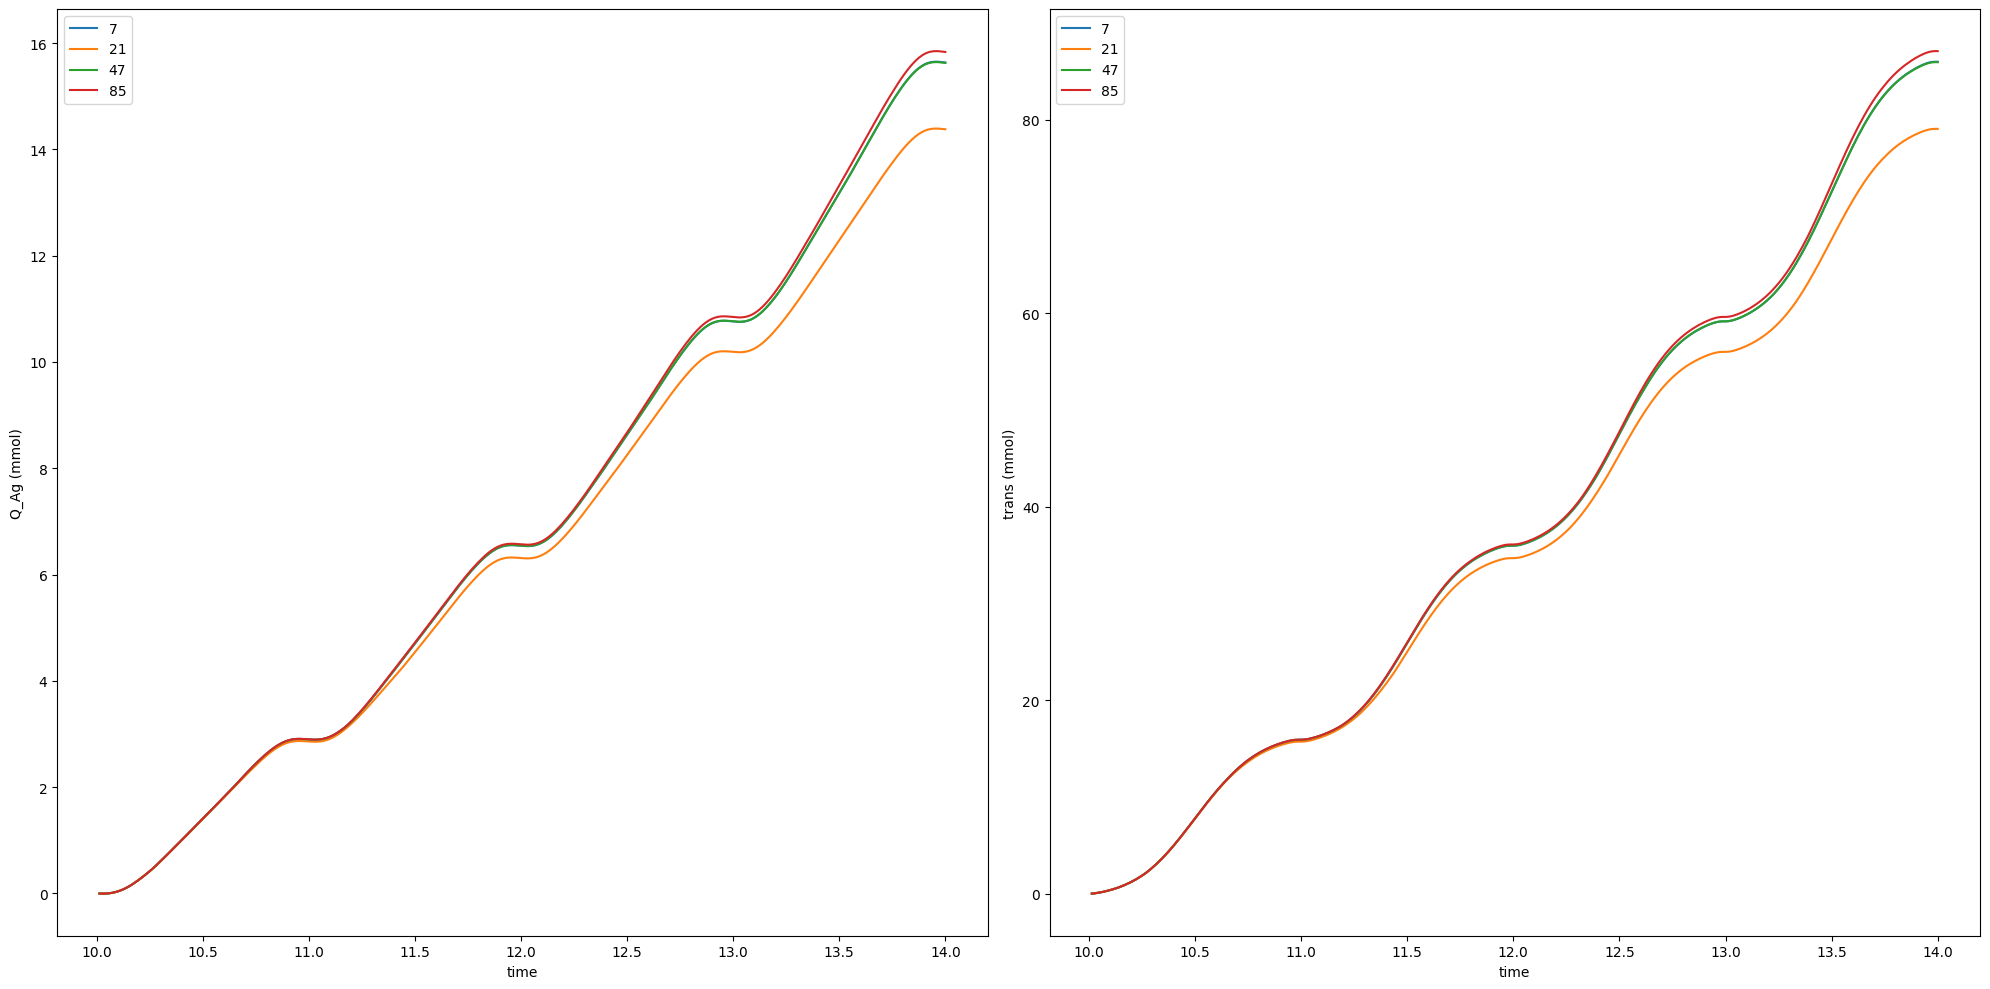

In [28]:

dotheplot(toplot = ['Q_Ag','trans'], df=dftemp, sizerows=20,sizecols=10)

In [7]:
def dotheplot(toplot, df, sizerows,sizecols):
    nrows = len(toplot)
    scenarios = [ "none"]
    ncols = len(scenarios)


    # higher than in the 1st paper
    # probably in part because i increased the kr of the roots
    cm3tommol = 1000*(1/18.01528)
    ratioTrans = 250 
    fig, ax = plt.subplots( nrows,ncols,figsize=(sizerows,sizecols))  # 2 rows, 2 columns
    for dd in df:
        for rowid, tipi in enumerate(toplot):        
            pset_ = int(dd['pSet'].unique()[0])
            scenario_ = dd['scenario'].unique()[0]
            
            factor = 1000
            if tipi == "trans":
                factor = cm3tommol
            ax[rowid].plot( dd['time'],dd[tipi]*factor,label=pset_)
            ax[rowid].set_xlabel('time')
            ax[rowid].set_ylabel(tipi+" (mmol C)")
            if rowid == 0:
                ax[rowid].legend() 
    plt.tight_layout()

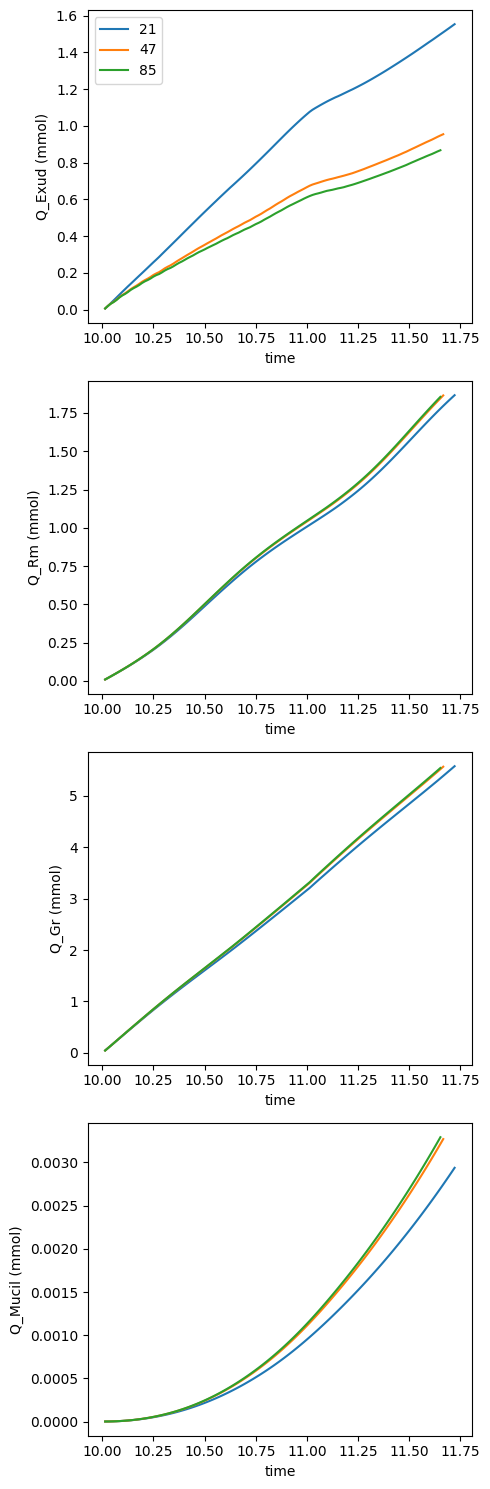

In [8]:

dotheplot(toplot = ['Q_Exud','Q_Rm','Q_Gr', 'Q_Mucil'], df=dftemp, sizerows=5,sizecols=15)

#plt.savefig('cusage.png')
plt.show()

In [271]:
def dotheplotwithzoom(toplot, df, sizerows,sizecols):
    nrows = len(toplot)
    ncols = 3
    scenarios = [ "baseline","earlyDry", "lateDry"]

    cm3tommol = 1000*(1/18.01528)

    # higher than in the 1st paper
    # probably in part because i increased the kr of the roots
    cm3tommol = 1000*(1/18.01528)
    ratioTrans = 250 
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols))  # 2 rows, 2 columns
    for dd in df:
        for rowid, tipi in enumerate(toplot):        
            pset_ = int(dd['pSet'].unique()[0])
            scenario_ = dd['scenario'].unique()[0]
            colid = np.where(scenario_==np.array(scenarios))[0][0]
            factor = 1000
            if tipi == "trans":
                factor = cm3tommol
            ax[rowid, colid].plot( dd['time'],dd[tipi]*factor,label=pset_)
            ax[rowid, colid].set_xlabel('time')
            if colid == 0:
                ax[rowid, colid].set_ylabel(tipi+" (mmol)")
            ax[rowid, colid].set_title(scenario_)
            if scenario_ == "lateDry":
                ax[rowid, colid].axvline(x=18, color='k', linestyle='--')
                ax[rowid, colid].axvline(x=25, color='k', linestyle='--')
            if scenario_ == "earlyDry":
                ax[rowid, colid].axvline(x=18, color='k', linestyle='--')
                ax[rowid, colid].axvline(x=11, color='k', linestyle='--')
            if rowid + colid == 0:
                ax[rowid, colid].legend() 

    plt.tight_layout()

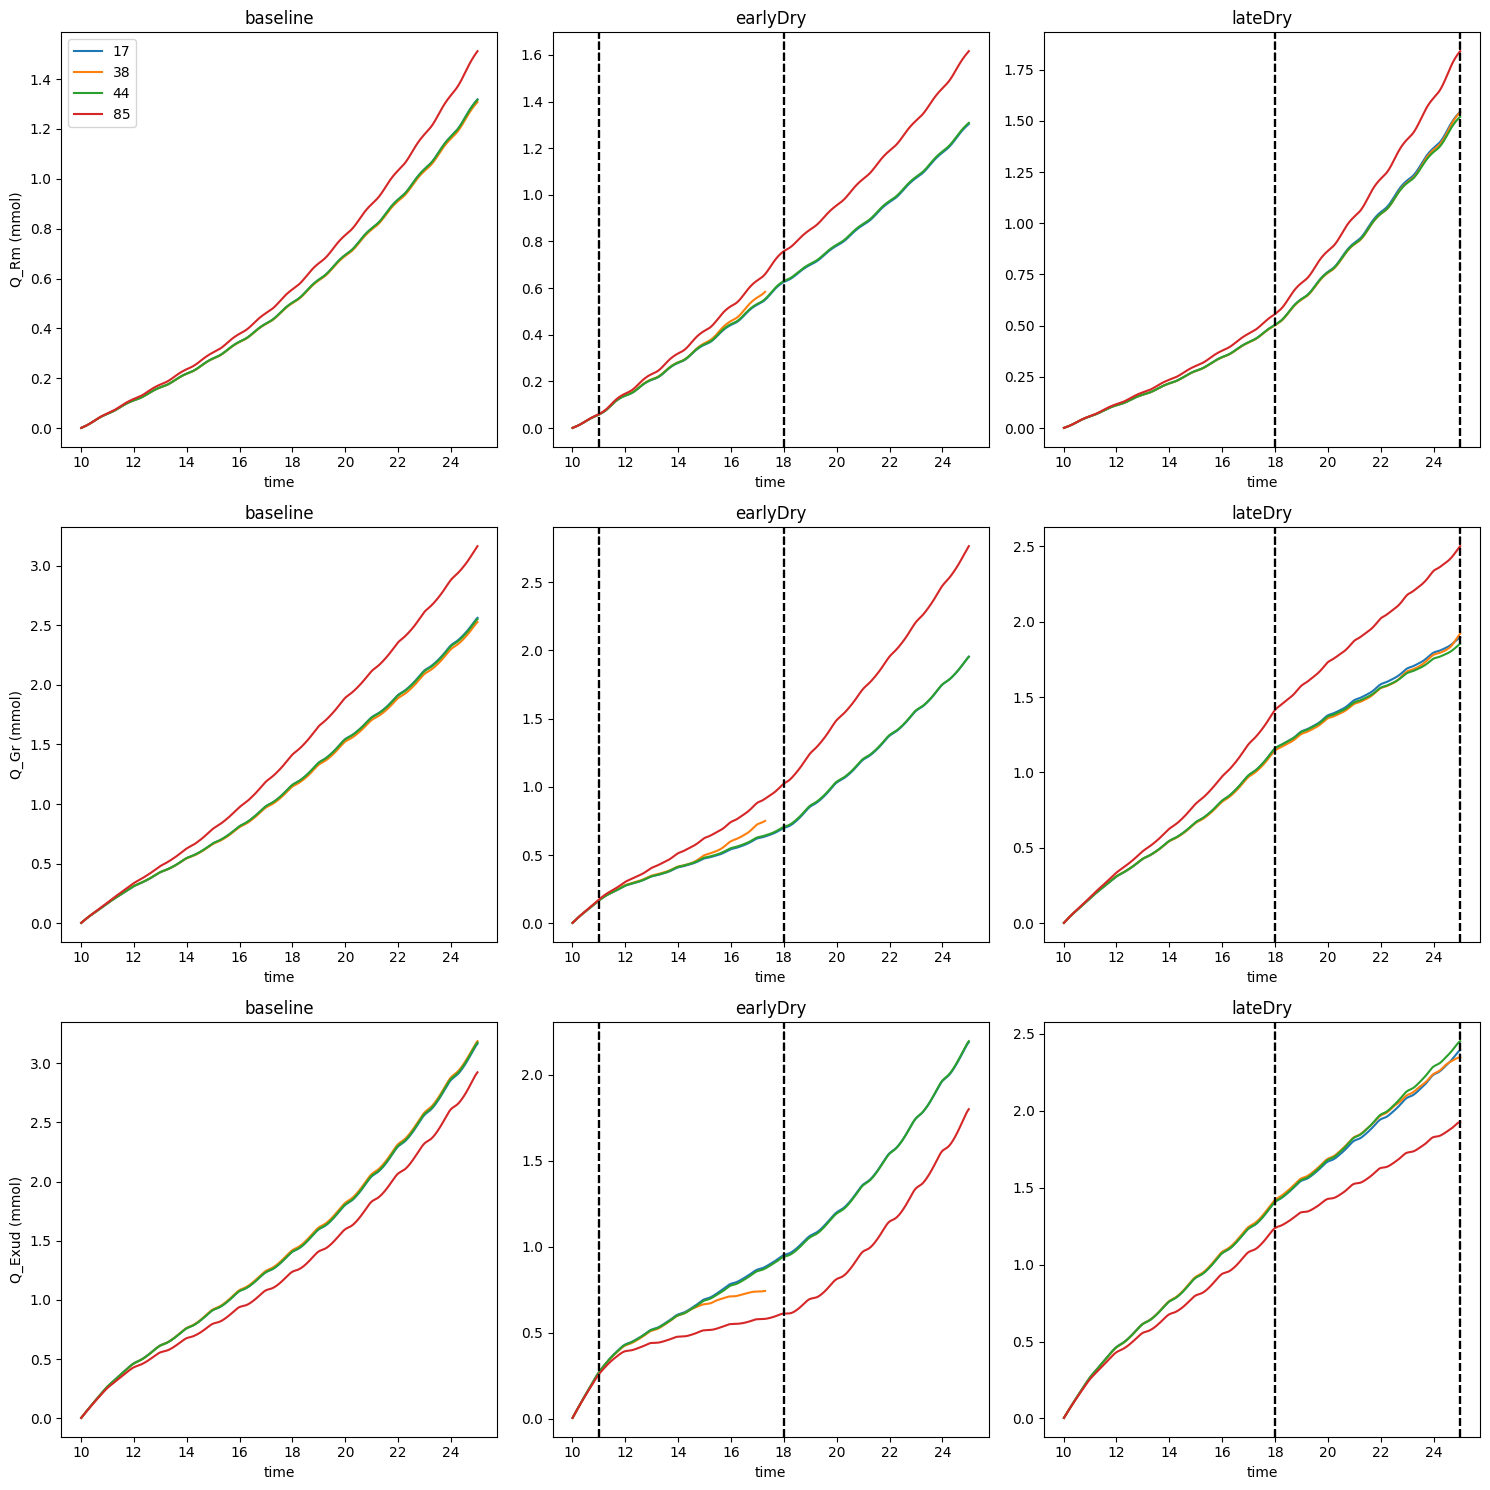

In [272]:

dotheplot(toplot = ['Q_Rm','Q_Gr','Q_Exud'], df=df, sizerows=15,sizecols=15)

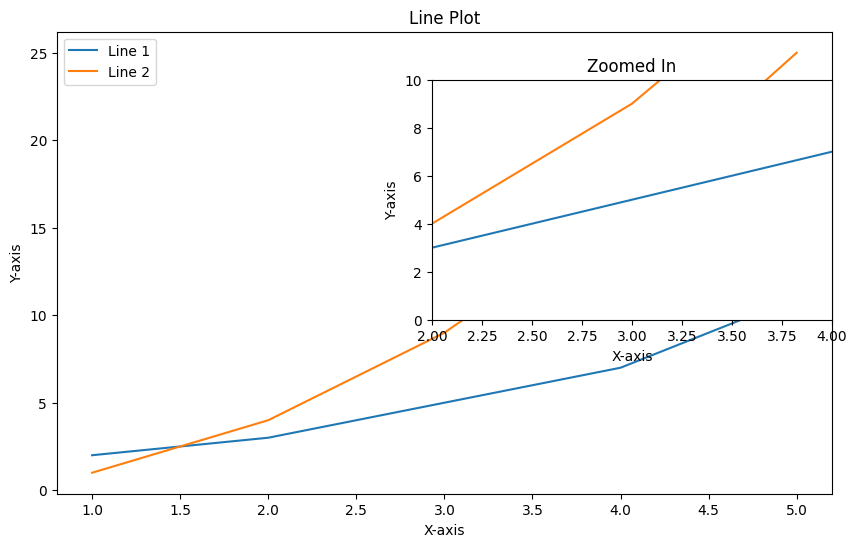

In [270]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y1 = [2, 3, 5, 7, 11]
y2 = [1, 4, 9, 16, 25]

# Plot the lines
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')
plt.legend()

# Define the zoomed-in section
zoom_start = 2
zoom_end = 4

# Add a zoomed-in section
plt.axes([0.5, 0.4, 0.4, 0.4])
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.xlim(zoom_start, zoom_end)
plt.ylim(0, 10)
plt.title('Zoomed In')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()

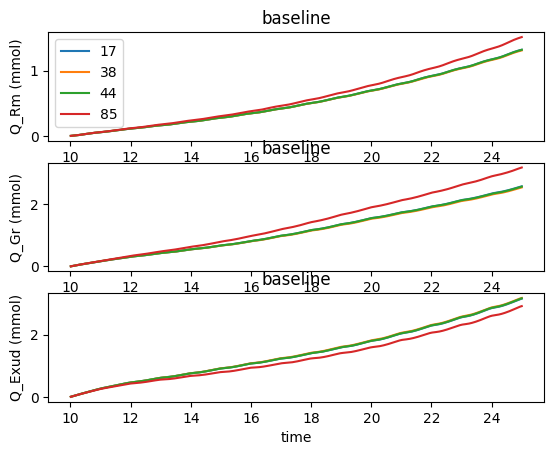

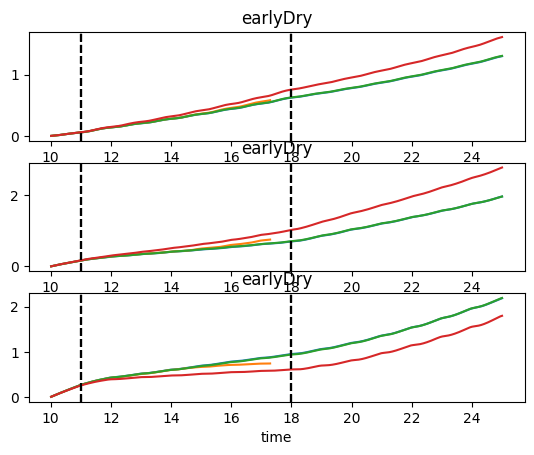

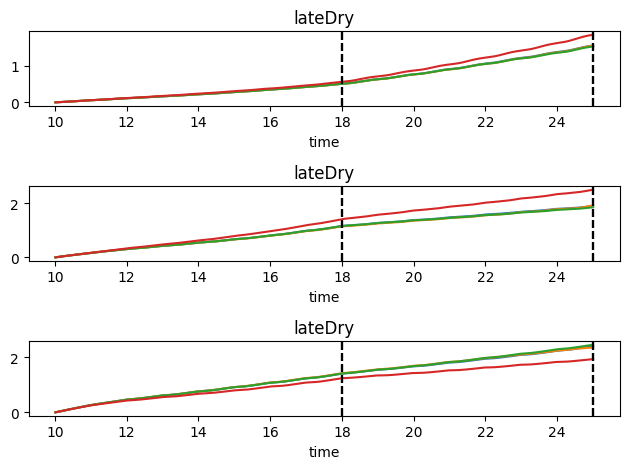

In [273]:

def dotheplotwithzoom(toplot, df, sizerows, sizecols):
    nrows = len(toplot)
    ncols = 3
    scenarios = ["baseline", "earlyDry", "lateDry"]

    cm3tommol = 1000 * (1 / 18.01528)

    # Create separate figures for each column
    figs = [plt.figure() for _ in range(ncols)]

    # Initialize separate axes arrays for each column
    axs = [[fig.add_subplot(nrows, 1, i+1) for i in range(nrows)] for fig in figs]

    for dd in df:
        for rowid, tipi in enumerate(toplot):
            pset_ = int(dd['pSet'].unique()[0])
            scenario_ = dd['scenario'].unique()[0]
            colid = np.where(scenario_ == np.array(scenarios))[0][0]
            factor = 1000
            if tipi == "trans":
                factor = cm3tommol
            axs[colid][rowid].plot(dd['time'], dd[tipi] * factor, label=pset_)
            axs[colid][rowid].set_xlabel('time')
            if colid == 0:
                axs[colid][rowid].set_ylabel(tipi + " (mmol)")
            axs[colid][rowid].set_title(scenario_)
            if scenario_ == "lateDry":
                axs[colid][rowid].axvline(x=18, color='k', linestyle='--')
                axs[colid][rowid].axvline(x=25, color='k', linestyle='--')
            if scenario_ == "earlyDry":
                axs[colid][rowid].axvline(x=18, color='k', linestyle='--')
                axs[colid][rowid].axvline(x=11, color='k', linestyle='--')
            if rowid + colid == 0:
                axs[colid][rowid].legend()

    plt.tight_layout()
    plt.show()


# Example usage:
# Assuming toplot, df, sizerows, and sizecols are defined
dotheplotwithzoom(toplot = ['Q_Rm','Q_Gr','Q_Exud'], df=df, sizerows=15,sizecols=15)